In [33]:
import torch
import torch.nn as nn
from sklearn.cluster import KMeans
import os
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import umap
import numpy as np
import pandas as pd
from sklearn.metrics import accuracy_score



In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data_dir = os.path.join("processed_data", "breast_g1")
gene_data = torch.load(os.path.join(data_dir, 'gene_encode.pth'))

spatial_data = torch.load(os.path.join(data_dir, 'coord_encode.pth'))
period_spatial_data = torch.load(os.path.join(data_dir, 'coord_period_encode.pth'))

img_data = torch.load(os.path.join(data_dir, 'img_encode.pth'))
gene_raw_data = torch.load(os.path.join(data_dir, 'raw_expression.pth'))
ground_truth = torch.load(os.path.join(data_dir, 'ground_truth.pth'))

cat_data = torch.cat((gene_data, spatial_data, img_data), dim=1).detach().numpy()
cat_raw_data = torch.cat((gene_raw_data, spatial_data, img_data), dim=1).detach().numpy()

In [25]:
def visualize_2d(z, ground_truth, reduce_dim = "umap"):
    if not isinstance(z, np.ndarray):
        z = z.detach().cpu().numpy()
    if not isinstance(ground_truth, np.ndarray):
        ground_truth = ground_truth.detach().cpu().numpy()
    vis_reducer = PCA(n_components=2) if reduce_dim != "umap" else umap.UMAP(n_components=2)
    z_2d = vis_reducer.fit_transform(z)
    plt.figure()
    plt.scatter(z_2d[:, 0], z_2d[:, 1], c=ground_truth, cmap="tab10", s=5, alpha=0.6)
    plt.title(f"2D View after with Cluster Coloring")
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.colorbar(label="Cluster")
    plt.show()

In [31]:
def get_centre_pred(z, reduce_dim = None, n_components = 10):
    if not isinstance(z, np.ndarray):
        z = z.detach().cpu().numpy()

    if reduce_dim == "pca":
        pca = PCA(n_components=n_components, random_state=42)
        z = pca.fit_transform(z)
    elif reduce_dim == "umap":
        reducer = umap.UMAP(n_components=n_components, random_state=42)
        z = reducer.fit_transform(z)
    else:
        print("Dimension not reduced")

    kmeans = KMeans(19, n_init=30, random_state=42)

    pred = kmeans.fit_predict(z)

    centroid = torch.tensor(kmeans.cluster_centers_, dtype=torch.float32, requires_grad=False, device=device)

    return centroid, pred

In [29]:
def eval_accuracy(pred, ground_truth):
    if not isinstance(ground_truth, np.ndarray):
        ground_truth = ground_truth.detach().cpu().numpy()
    y_true = np.asarray(ground_truth) - 1
    y_pred = np.asarray(pred)
    df = pd.DataFrame({"true": y_true, "pred": y_pred})
    majority_map = (
        df.groupby('pred')['true']
        .agg(lambda x: x.value_counts().idxmax())
        .to_dict()
    )
    y_pred_mapped = df['pred'].map(majority_map).to_numpy()
    acc = accuracy_score(y_true, y_pred_mapped) 
    # cm = confusion_matrix(y_true, y_pred_mapped)
    # acc = accuracy_score(y_true, y_pred)
    print("Accuracy:", acc)

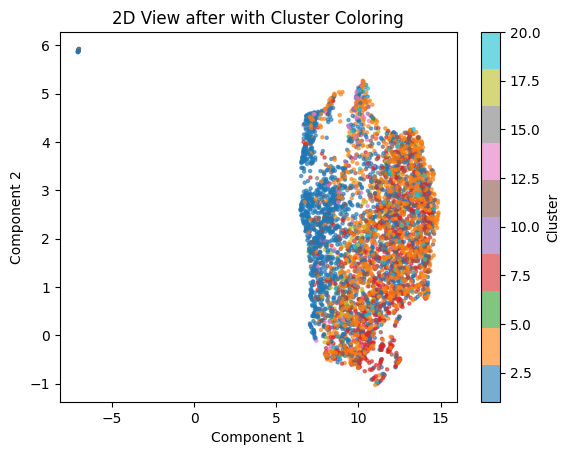

Dimension not reduced
Accuracy: 0.4140084764666518


In [ ]:
# cat
visualize_2d(cat_data, ground_truth)
_, pred = get_centre_pred(cat_data)
eval_accuracy(pred, ground_truth)


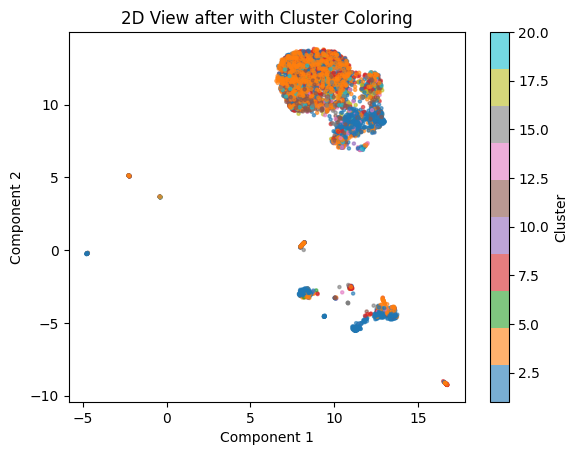

Dimension not reduced
Accuracy: 0.45460629043051526


In [ ]:
#cat norm
scaler = MinMaxScaler(feature_range=(-1, 1))
normalized = scaler.fit_transform(cat_data)

visualize_2d(normalized, ground_truth)
_, pred = get_centre_pred(normalized)
eval_accuracy(pred, ground_truth)

C:\Users\b4088\AppData\Local\Temp\ipykernel_36820\1114469693.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  gene_data_broadcast = gene_raw_data + pad_spatial_data


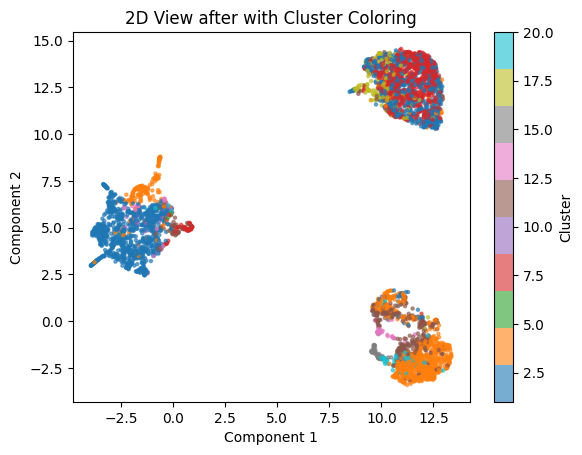

Dimension not reduced
Accuracy: 0.6517956725407094


In [51]:
#cat gene_data broadcast
pad_spatial_data = np.pad(period_spatial_data, ((0, 0), (0, 1)), mode='constant', constant_values=0)
gene_data_broadcast = gene_raw_data + pad_spatial_data

visualize_2d(gene_data_broadcast, ground_truth)
_, pred = get_centre_pred(gene_data_broadcast)
eval_accuracy(pred, ground_truth)

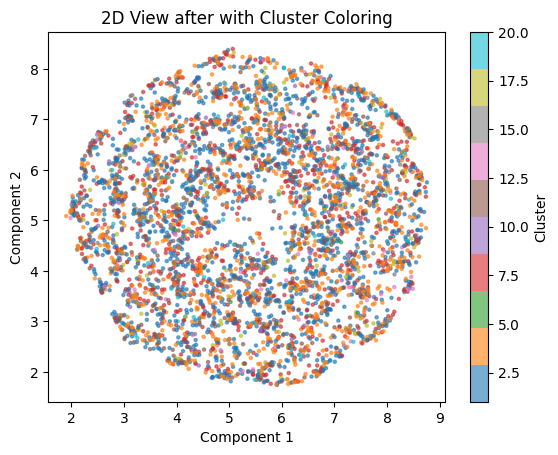

Dimension not reduced
Accuracy: 0.22997992415792995


In [ ]:
#period_spatial_data
visualize_2d(period_spatial_data, ground_truth)
_, pred = get_centre_pred(period_spatial_data)
eval_accuracy(pred, ground_truth)

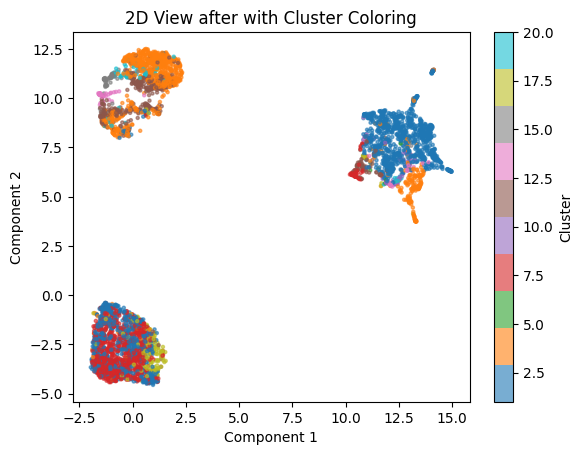

Dimension not reduced
Accuracy: 0.6555877760428285


In [41]:
# cat_raw_data
visualize_2d(cat_raw_data, ground_truth)
_, pred = get_centre_pred(cat_raw_data)
eval_accuracy(pred, ground_truth)

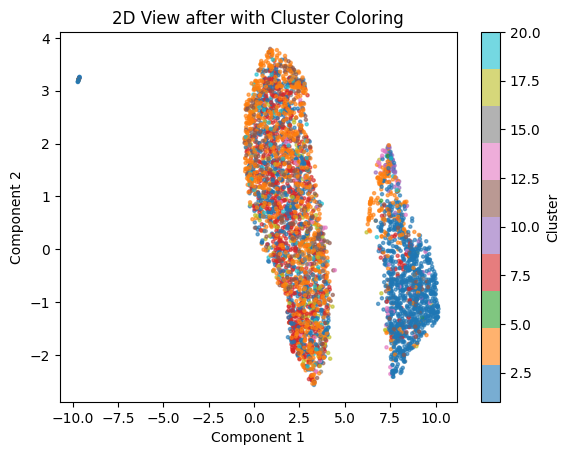

Dimension not reduced
Accuracy: 0.47535132723622575


In [42]:
# cat_raw_data norm
scaler = MinMaxScaler(feature_range=(-1, 1))
normalized = scaler.fit_transform(cat_raw_data)

visualize_2d(normalized, ground_truth)
_, pred = get_centre_pred(normalized)
eval_accuracy(pred, ground_truth)

C:\Users\b4088\AppData\Local\Temp\ipykernel_36820\1545097238.py:3: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  gene_data_broadcast = gene_raw_data + pad_spatial_data


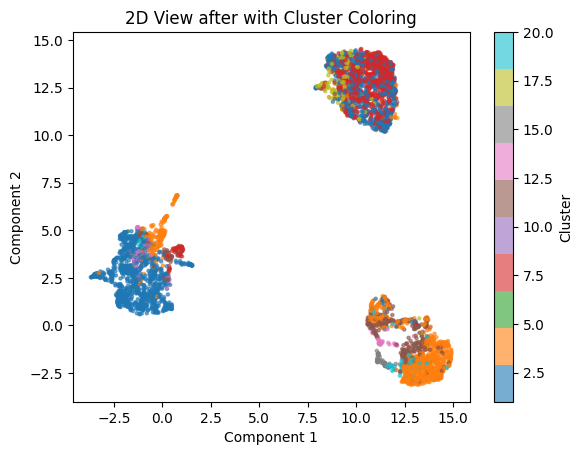

Dimension not reduced
Accuracy: 0.6517956725407094


In [45]:
#raw gene data broadcast
pad_spatial_data = np.pad(period_spatial_data, ((0, 0), (0, 1)), mode='constant', constant_values=0)
gene_data_broadcast = gene_raw_data + pad_spatial_data

visualize_2d(gene_data_broadcast, ground_truth)
_, pred = get_centre_pred(gene_data_broadcast)
eval_accuracy(pred, ground_truth)

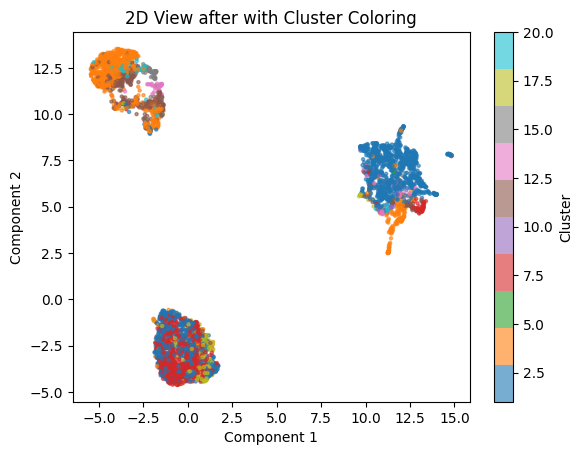

Dimension not reduced
Accuracy: 0.657149230426054


In [48]:
# cat_per
cat_per = torch.cat((gene_raw_data, period_spatial_data, img_data), dim=1).detach().numpy()

visualize_2d(cat_per, ground_truth)
_, pred = get_centre_pred(cat_per)
eval_accuracy(pred, ground_truth)

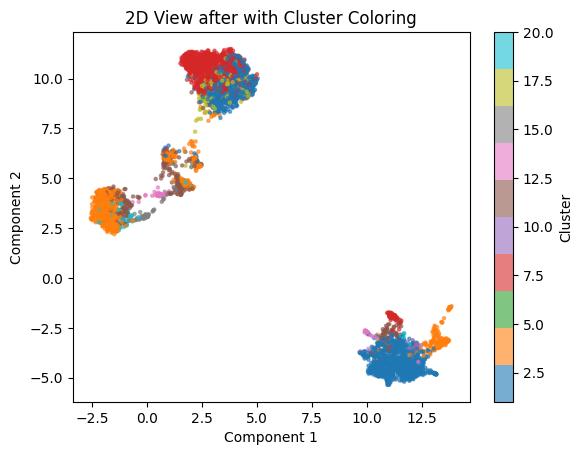

Dimension not reduced
Accuracy: 0.7312067811733214


In [49]:
scaler = MinMaxScaler(feature_range=(-1, 1))
normalized = scaler.fit_transform(gene_raw_data)

visualize_2d(normalized, ground_truth)
_, pred = get_centre_pred(normalized)
eval_accuracy(pred, ground_truth)